In [1]:
from google.colab import drive
import os
import pandas as pd
import numpy as np

#Load the dataset
drive.mount('/content/drive',force_remount=True)
file_path = "/content/drive/My Drive/Problem_Statements/datasets/clustering_data.csv"

# Function to convert column to float
def convert_column(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path, converters={9: convert_column, 10: convert_column})
print(f"Rows in original DataFrame: {len(df)}")
# Drop rows with NaN values in the 9th and 10th columns
df = df.dropna(subset=[df.columns[9], df.columns[10]])
print(f"Rows after removing non-numeric 9th and 10th column: {len(df)}")
# Filter the DataFrame for rows where StateName is "TAMIL NADU"
filtered_df = df[df["StateName"] == "TAMIL NADU"]
print(f"Rows in filtered DataFrame (Tamil Nadu): {len(filtered_df)}")
# Remove duplicate rows based on all columns
filtered_df = filtered_df.drop_duplicates()
print(f"Rows after removing duplicate rows: {len(filtered_df)}")
filtered_df.head()

Mounted at /content/drive
Rows in original DataFrame: 157126
Rows after removing non-numeric 9th and 10th column: 148044
Rows in filtered DataFrame (Tamil Nadu): 11785
Rows after removing duplicate rows: 11785


,CircleName,RegionName,DivisionName,OfficeName,Pincode,OfficeType,Delivery,District,StateName,Latitude,Longitude
1733,Tamilnadu Circle,"Central Region, Trichirapalli",Tiruchirapalli Division,ETTARAI S.O.,639103,PO,Non Delivery,TIRUCHIRAPPALLI,TAMIL NADU,10.845278,78.596389
5428,Tamilnadu Circle,Chennai City Region,Pondicherry Division,Valudareddy S.O,605403,PO,Delivery,VILLUPURAM,TAMIL NADU,12.067166,79.395827
5900,Tamilnadu Circle,"Western Region, Coimbatore",Dharmapuri Division,Dharmapuri Combined Court Building S. O,636705,PO,Non Delivery,DHARMAPURI,TAMIL NADU,12.093300,78.202000
15612,Tamilnadu Circle,Chennai City Region,Tambaram Division,Perumbakkam S.O,600100,PO,Non Delivery,CHENGALPATTU,TAMIL NADU,12.905914,80.201454
52941,Tamilnadu Circle,"Southern Region, Madurai",Tirunelveli Division,Keela Kaduvetti BO,627152,BO,Delivery,TIRUNELVELI,TAMIL NADU,8.570259,77.621218


Total points: 11785
Points included: 11394
Points excluded: 391
Map extent: [Longitude: 76.04 to 80.94, Latitude: 7.50 to 13.97]


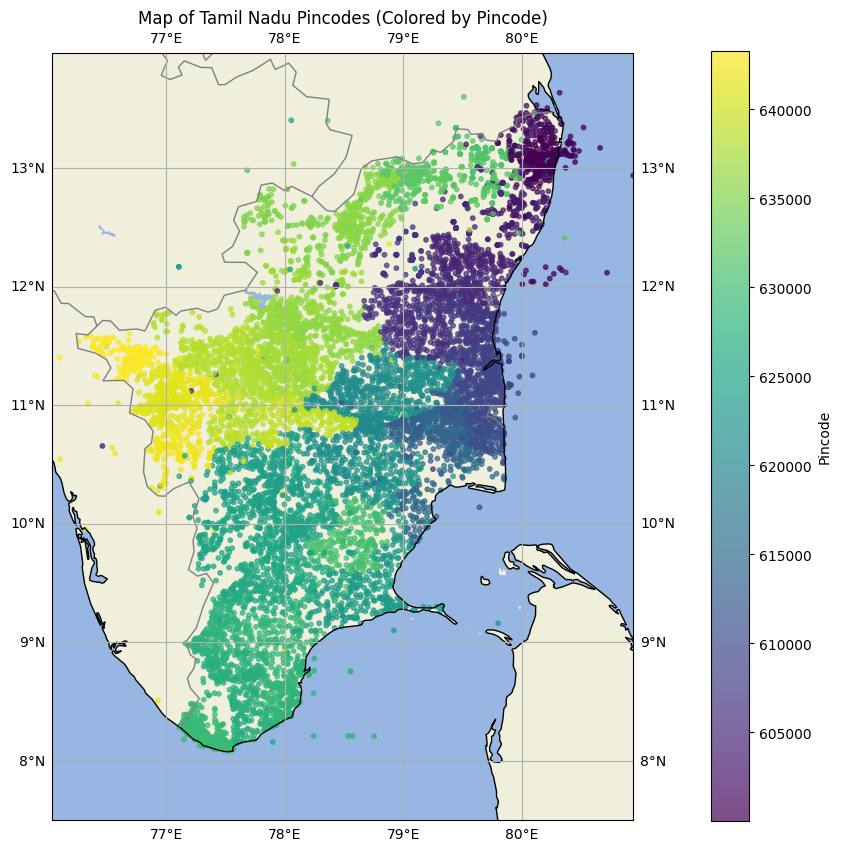

In [2]:
import matplotlib.pyplot as plt
#!pip install cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# Calculate the bounding box using percentiles to exclude outliers
# Found these percentiles by trial and error method
min_lon = np.percentile(filtered_df['Longitude'], 4)
max_lon = np.percentile(filtered_df['Longitude'], 99)
min_lat = np.percentile(filtered_df['Latitude'], 1)
max_lat = np.percentile(filtered_df['Latitude'], 96)

# Add a buffer to the bounding box
# Value decided using trial and error method
buffer = 0.7
min_lon -= buffer
max_lon += buffer
min_lat -= buffer
max_lat += buffer

# Create a mask for points within the bounding box
mask = (
    (filtered_df['Longitude'] >= min_lon) &
    (filtered_df['Longitude'] <= max_lon) &
    (filtered_df['Latitude'] >= min_lat) &
    (filtered_df['Latitude'] <= max_lat)
)
# Apply the mask to filter out outliers
filtered_df_no_outliers = filtered_df[mask]
# Print info about excluded points
print(f"Total points: {len(filtered_df)}")
print(f"Points included: {len(filtered_df_no_outliers)}")
print(f"Points excluded: {len(filtered_df) - len(filtered_df_no_outliers)}")

# Print the extent for reference
print(f"Map extent: [Longitude: {min_lon:.2f} to {max_lon:.2f}, Latitude: {min_lat:.2f} to {max_lat:.2f}]")
# Create a new figure
fig = plt.figure(figsize=(10, 10))

# Create a GeoAxes in the plate carrée projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Set the extent of the map based on the calculated values
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
# Add ocean, land, and lakes
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
# Add state borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Create a color map
cmap = plt.get_cmap('viridis')
# Normalize the pincode values to the range [0, 1]
norm = Normalize(vmin=filtered_df_no_outliers['Pincode'].min(), vmax=filtered_df_no_outliers['Pincode'].max())
# Plot the pincodes with colors based on their values
scatter = ax.scatter(filtered_df_no_outliers['Longitude'],
                     filtered_df_no_outliers['Latitude'],
                     c=filtered_df_no_outliers['Pincode'],
                     cmap=cmap,
                     norm=norm,
                     s=10,  # Size of the points
                     alpha=0.7,
                     transform=ccrs.PlateCarree())
# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label('Pincode')
# Add title
plt.title("Map of Tamil Nadu Pincodes (Colored by Pincode)")
# Show the plot
plt.show()

In [3]:
def kmeans(data, k, max_iters=200, tol=1e-4):
    # Initialize the centroids by randomly selecting k data points
    idx = np.random.choice(len(data), k, replace=False)
    centroids = data[idx, :]
    for _ in range(max_iters):
        # Calculate distances from each point to each centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        # Assign each point to the closest centroid
        labels = np.argmin(distances, axis=1)
        # Calculate new centroids as the mean of points in each cluster
        new_centroids = np.array([data[labels == i].mean(axis=0) if np.any(labels == i) else centroids[i] for i in range(k)])
        # Check for convergence (if centroids do not change significantly)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
    # Organize points by cluster for the final output
    clusters = [data[labels == i] for i in range(k)]
    tot_var = np.sum([np.sum((cluster - np.mean(cluster, axis=0))**2) for cluster in clusters if len(cluster) > 0])
    return tot_var, centroids, labels

Optimal number of clusters: 6


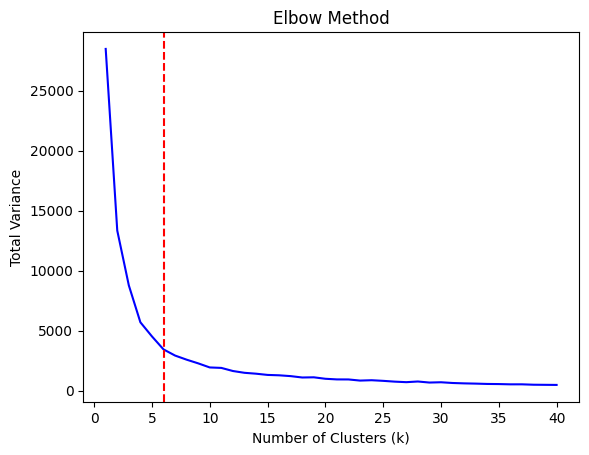

In [4]:
# Clustering based on Longitude and Latitude

# Find the optimal number of clusters using the elbow method
#to reach the optimal no. of k we don't need to go on for all unique pincodes
max_k = len(set(filtered_df_no_outliers['Pincode']))//50
var = np.zeros(max_k)
for k in range(1, max_k + 1):
    var[k-1], _, _ = kmeans(np.column_stack((filtered_df_no_outliers['Longitude'], filtered_df_no_outliers['Latitude'])), k)
    #print(f'k = {k} , tot_var = {var[k-1]}')
# Find the elbow point
m = 0
elbow_point = 0
A = var[-1]-var[0]
B = -max_k
C = (max_k+1)*var[0] - var[-1]
for i in range(1,1+max_k):
    if (m < np.abs(A*i + B*var[i-1] + C)/np.sqrt(A**2 + B**2)):
        m = np.abs(A*i + B*var[i-1] + C)/np.sqrt(A**2 + B**2)
        elbow_point = i
print(f'Optimal number of clusters: {elbow_point}')
# Plot the Elbow Method with the elbow point
plt.plot(range(1, max_k + 1), var, 'b-')
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Variance')
plt.title('Elbow Method')
plt.show()

Map extent: [Longitude: 76.04 to 80.94, Latitude: 7.50 to 13.97]


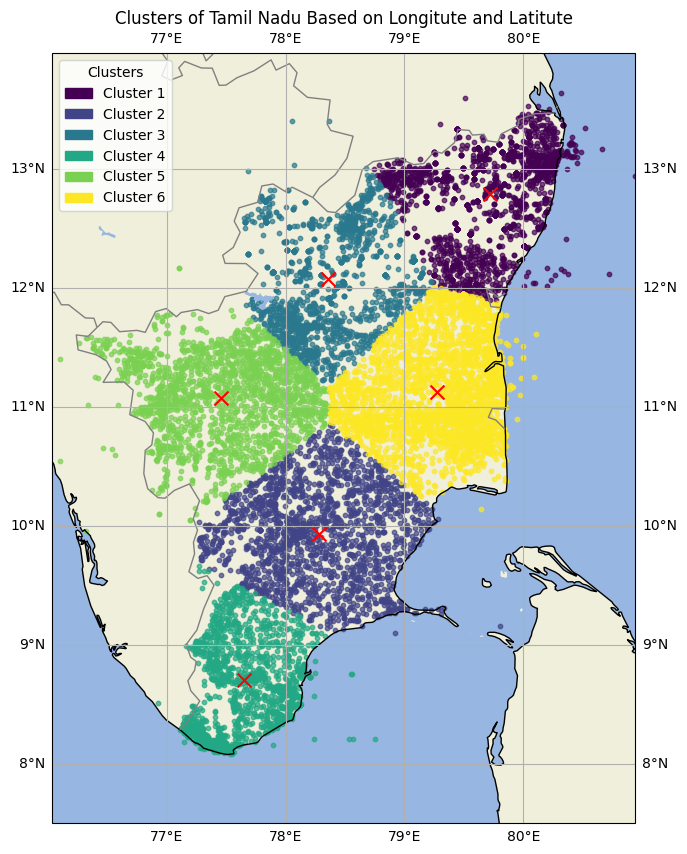

In [5]:
from matplotlib.patches import Patch

var, centroids, labels = kmeans(np.column_stack((filtered_df_no_outliers['Longitude'], filtered_df_no_outliers['Latitude'])), elbow_point)
# Print the extent for reference
print(f"Map extent: [Longitude: {min_lon:.2f} to {max_lon:.2f}, Latitude: {min_lat:.2f} to {max_lat:.2f}]")
# Create a new figure
fig = plt.figure(figsize=(10, 10))
# Create a GeoAxes in the plate carrée projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Set the extent of the map based on the calculated values
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
# Add ocean, land, and lakes
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
# Add state borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Normalize the cluster labels to the range [0, 1]
norm = Normalize(vmin=0, vmax=elbow_point - 1)
# Create a list to hold the legend entries
legend_entries = []

# Plot each cluster with a different color
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    scatter = ax.scatter(cluster_points['Longitude'],
                         cluster_points['Latitude'],
                         color=cmap(norm(cluster_label)),
                         s=10,  # Size of the points
                         alpha=0.7,
                         transform=ccrs.PlateCarree())
    legend_entries.append(Patch(color=cmap(norm(cluster_label)), label=f'Cluster {cluster_label + 1}'))

# Add centroids to the plot
centroid_scatter = ax.scatter(centroids[:, 0],
                              centroids[:, 1],
                              color='red',
                              marker='x',
                              s=100,  # Size of the centroid markers
                              transform=ccrs.PlateCarree())
# Add title and legend
plt.title("Clusters of Tamil Nadu Based on Longitute and Latitute")
plt.legend(handles=legend_entries, loc='best', title='Clusters')
plt.show()

In [6]:
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    print(f"Cluster {cluster_label + 1} has {len(cluster_points)} points.")
print("\n")
pincodes = []
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    pin = set(cluster_points['Pincode'])
    pincodes.append(pin)
    print(f"Cluster {cluster_label + 1} has {len(pin)} pincodes")
print("\n")
for i in range(elbow_point):
  for j in range(i+1,elbow_point):
    print(f"Cluster {i+1} and Cluster {j+1} have {len(pincodes[i].intersection(pincodes[j]))} common pincodes")
print("\n")
print(set(filtered_df_no_outliers['OfficeType']))
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    office = cluster_points['OfficeType'].mode()[0]
    print(f"Cluster {cluster_label + 1} has mostly {office} OfficeType, {cluster_points['OfficeType'].value_counts()[office]*100/len(cluster_points)}%")
print("\n")
print(set(filtered_df_no_outliers['Delivery']))
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    delivery = cluster_points['Delivery'].mode()[0]
    print(f"Cluster {cluster_label + 1} has mostly {delivery} type , {cluster_points['Delivery'].value_counts()[delivery]*100/len(cluster_points)}%")
print("\n")
division = []
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    div = set(cluster_points['DivisionName'])
    division.append(div)
    print(f"Cluster {cluster_label + 1} has {len(div)} divisions")
print("\n")
for i in range(elbow_point):
  for j in range(i+1,elbow_point):
    print(f"Cluster {i+1} and Cluster {j+1} have {len(division[i].intersection(division[j]))} common divisions")
print("\n")
print(set(filtered_df_no_outliers['RegionName']))
for cluster_label in range(elbow_point):
    cluster_points = filtered_df_no_outliers[labels == cluster_label]
    print(f"Cluster {cluster_label + 1} has {set(cluster_points['RegionName'])} regions")

Cluster 1 has 1981 points.
Cluster 2 has 1902 points.
Cluster 3 has 1613 points.
Cluster 4 has 1324 points.
Cluster 5 has 1935 points.
Cluster 6 has 2639 points.


Cluster 1 has 403 pincodes
Cluster 2 has 363 pincodes
Cluster 3 has 278 pincodes
Cluster 4 has 314 pincodes
Cluster 5 has 393 pincodes
Cluster 6 has 522 pincodes


Cluster 1 and Cluster 2 have 4 common pincodes
Cluster 1 and Cluster 3 have 45 common pincodes
Cluster 1 and Cluster 4 have 3 common pincodes
Cluster 1 and Cluster 5 have 8 common pincodes
Cluster 1 and Cluster 6 have 24 common pincodes
Cluster 2 and Cluster 3 have 5 common pincodes
Cluster 2 and Cluster 4 have 26 common pincodes
Cluster 2 and Cluster 5 have 43 common pincodes
Cluster 2 and Cluster 6 have 34 common pincodes
Cluster 3 and Cluster 4 have 2 common pincodes
Cluster 3 and Cluster 5 have 20 common pincodes
Cluster 3 and Cluster 6 have 31 common pincodes
Cluster 4 and Cluster 5 have 4 common pincodes
Cluster 4 and Cluster 6 have 2 common pincodes
Cluster

My inference from the clustering is that:


1.   Whole state has mostly Delivery type and BO office type.
2.   It does a decent job of clustering such that clusters have equally distributed data points.
3.   But all clusters have almost same observations.

So, the inference can be that all the regions of the state has similar faetures.



In [7]:
# Creating an dataset containing unique pincodes
df_pin = filtered_df_no_outliers.groupby('Pincode').apply(lambda x: x.head(1)).reset_index(drop=True)
print(df_pin.shape)

(2034, 11)


Optimal number of clusters: 5


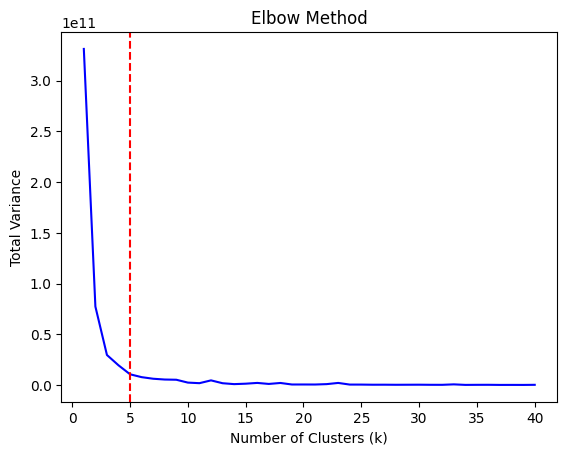

In [8]:
# Clustering based on Longitude, Latitude and Pincode

# Find the optimal number of clusters using the elbow method
#to reach the optimal no. of k we don't need to go on for all unique pincodes
max_k = len(set(filtered_df_no_outliers['Pincode']))//50
var = np.zeros(max_k)
for k in range(1, max_k + 1):
    var[k-1], _, _ = kmeans(np.column_stack((df_pin['Longitude'], df_pin['Latitude'], df_pin['Pincode'])), k)
    #print(f'k = {k} , tot_var = {var[k-1]}')
# Find the elbow point
m = 0
elbow_point = 0
A = var[-1]-var[0]
B = -max_k
C = (max_k+1)*var[0] - var[-1]
for i in range(1,1+max_k):
    if (m < np.abs(A*i + B*var[i-1] + C)/np.sqrt(A**2 + B**2)):
        m = np.abs(A*i + B*var[i-1] + C)/np.sqrt(A**2 + B**2)
        elbow_point = i
print(f'Optimal number of clusters: {elbow_point}')
# Plot the Elbow Method with the elbow point
plt.plot(range(1, max_k + 1), var, 'b-')
plt.axvline(x=elbow_point, color='r', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Total Variance')
plt.title('Elbow Method')
plt.show()

Map extent: [Longitude: 76.04 to 80.94, Latitude: 7.50 to 13.97]


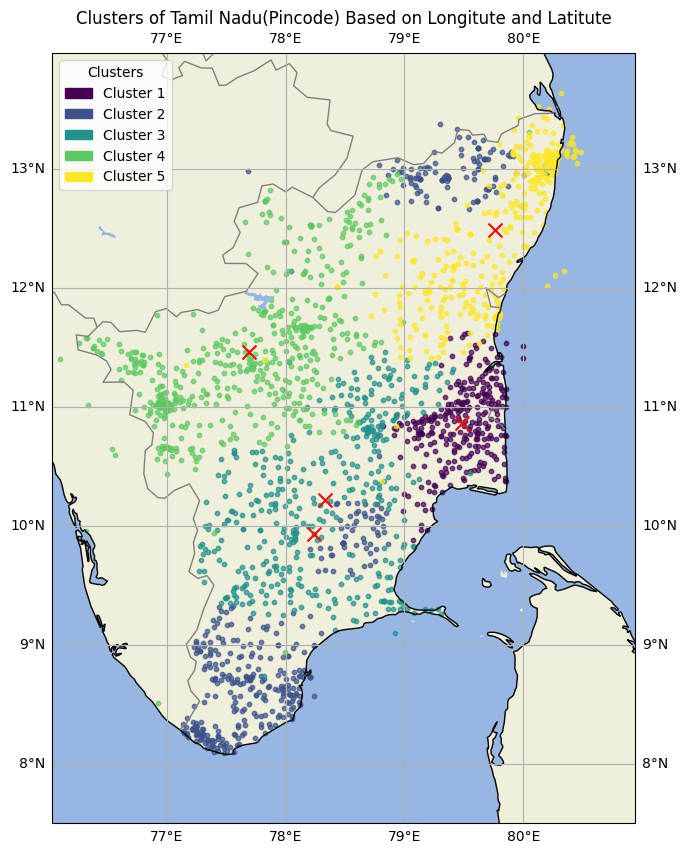

In [9]:
var, centroids, labels = kmeans(np.column_stack((df_pin['Longitude'], df_pin['Latitude'], df_pin['Pincode'])), elbow_point)
# Print the extent for reference
print(f"Map extent: [Longitude: {min_lon:.2f} to {max_lon:.2f}, Latitude: {min_lat:.2f} to {max_lat:.2f}]")
# Create a new figure
fig = plt.figure(figsize=(10, 10))
# Create a GeoAxes in the plate carrée projection
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
# Set the extent of the map based on the calculated values
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# Add coastlines and country borders
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
# Add ocean, land, and lakes
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.LAKES)
# Add state borders
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')
# Add gridlines
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# Normalize the cluster labels to the range [0, 1]
norm = Normalize(vmin=0, vmax=elbow_point - 1)
# Create a list to hold the legend entries
legend_entries = []
# Plot each cluster with a different color
for cluster_label in range(elbow_point):
    cluster_points = df_pin[labels == cluster_label]
    scatter = ax.scatter(cluster_points['Longitude'],
                         cluster_points['Latitude'],
                         color=cmap(norm(cluster_label)),
                         s=10,  # Size of the points
                         alpha=0.7,
                         transform=ccrs.PlateCarree())
    legend_entries.append(Patch(color=cmap(norm(cluster_label)), label=f'Cluster {cluster_label + 1}'))
# Add centroids to the plot
centroid_scatter = ax.scatter(centroids[:, 0],
                              centroids[:, 1],
                              color='red',
                              marker='x',
                              s=100,  # Size of the centroid markers
                              transform=ccrs.PlateCarree(),
                              label='Centroids')

# Add title and legend
plt.title("Clusters of Tamil Nadu(Pincode) Based on Longitute and Latitute")
plt.legend(handles=legend_entries, loc='best', title='Clusters')
plt.show()

In [10]:
for cluster_label in range(elbow_point):
    cluster_points = df_pin[labels == cluster_label]
    print(f"Cluster {cluster_label + 1} has {len(cluster_points)} points.")
print("\n")
print(set(df_pin['OfficeType']))
for cluster_label in range(elbow_point):
    cluster_points = df_pin[labels == cluster_label]
    office = cluster_points['OfficeType'].mode()[0]
    print(f"Cluster {cluster_label + 1} has mostly {office} OfficeType, {cluster_points['OfficeType'].value_counts()[office]*100/len(cluster_points)}%")
print("\n")
print(set(df_pin['Delivery']))
for cluster_label in range(elbow_point):
    cluster_points = df_pin[labels == cluster_label]
    delivery = cluster_points['Delivery'].mode()[0]
    print(f"Cluster {cluster_label + 1} has mostly {delivery} type , {cluster_points['Delivery'].value_counts()[delivery]*100/len(cluster_points)}%")
print("\n")
division = []
for cluster_label in range(elbow_point):
    cluster_points = df_pin[labels == cluster_label]
    div = set(cluster_points['DivisionName'])
    division.append(div)
    print(f"Cluster {cluster_label + 1} has {len(div)} divisions")
print("\n")
for i in range(elbow_point):
  for j in range(i+1,elbow_point):
    print(f"Cluster {i+1} and Cluster {j+1} have {len(division[i].intersection(division[j]))} common divisions")
print("\n")
print(set(df_pin['RegionName']))
for cluster_label in range(elbow_point):
    cluster_points = df_pin[labels == cluster_label]
    print(f"Cluster {cluster_label + 1} has {set(cluster_points['RegionName'])} regions")

Cluster 1 has 283 points.
Cluster 2 has 451 points.
Cluster 3 has 418 points.
Cluster 4 has 523 points.
Cluster 5 has 359 points.


{'PO', 'HO', 'BO'}
Cluster 1 has mostly BO OfficeType, 80.56537102473499%
Cluster 2 has mostly BO OfficeType, 81.59645232815964%
Cluster 3 has mostly BO OfficeType, 88.03827751196172%
Cluster 4 has mostly BO OfficeType, 86.80688336520076%
Cluster 5 has mostly BO OfficeType, 72.42339832869081%


{'Delivery', 'Non Delivery'}
Cluster 1 has mostly Delivery type , 89.04593639575971%
Cluster 2 has mostly Delivery type , 92.46119733924613%
Cluster 3 has mostly Delivery type , 95.69377990430623%
Cluster 4 has mostly Delivery type , 89.2925430210325%
Cluster 5 has mostly Delivery type , 86.62952646239555%


Cluster 1 has 9 divisions
Cluster 2 has 12 divisions
Cluster 3 has 9 divisions
Cluster 4 has 13 divisions
Cluster 5 has 11 divisions


Cluster 1 and Cluster 2 have 0 common divisions
Cluster 1 and Cluster 3 have 2 common divisions
Cluster 1 and Cluster 4 have 1 

While visualizing the map, we can say that it is a poor clustering.
But when we see the clustering inferences,
we can say that the data points are separated according to the division.

But still BO office type and delivery type is the prominent.
Thus we can conclude whole state is consistent in terma of office type and delivery type.